# Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Hyperparameters

In [2]:
FUTURE = 20
BATCH_SIZE = 32
EPOCHS = 200
PAST = 20

# Plotter Functions

In [3]:
def plot_results(title, loss, val_loss):
    fig, (ax1) = plt.subplots(1, 1)
    fig.tight_layout(pad=4)
    fig.suptitle(title)
    ax1.set_title('Loss')
    ax1.plot(loss)
    ax1.plot(val_loss)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['training', 'validation'], loc='upper right')
    fig.show()

In [4]:
def plot_predictions(model, scaler, x_norm, y_norm, title):
    y_predict_norm = model.predict(x_norm)
    y_predict_true = np.squeeze(scaler.inverse_transform(y_predict_norm))
    y_true = np.squeeze(scaler.inverse_transform([y_norm]))
    plt.plot(y_predict_true)
    plt.plot(y_true)
    plt.title(title)
    plt.ylabel('Price')
    plt.legend (["Predictions", "True values"])
    plt.show()

# Dataset

In [5]:
def create_dataset(csv_path):
    df = pd.read_csv(csv_path)
    dataset = np.array([df['value'].to_numpy()]).T
    return dataset

In [6]:
train_data = create_dataset('train.csv')
val_data = create_dataset('test.csv')

print(train_data.shape)
print(val_data.shape)

(1000, 1)
(461, 1)


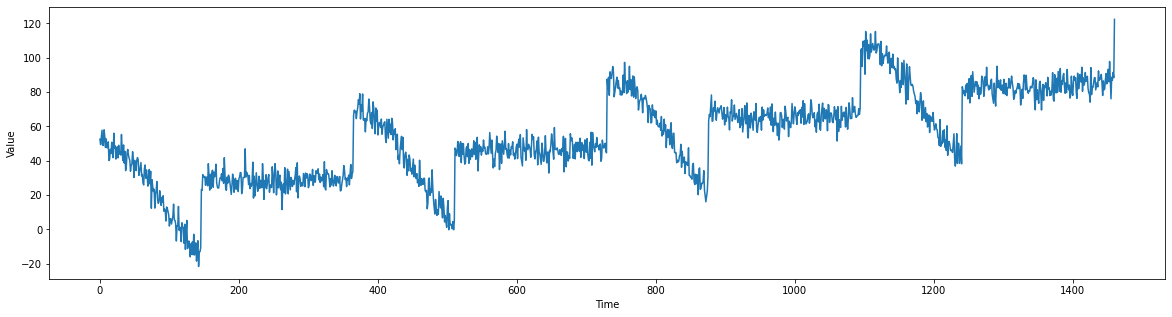

In [7]:
# Plot train and val time series
plt.figure(figsize=(20, 5))
plt.plot(np.concatenate((train_data, val_data)))
plt.ylabel('Value')
plt.xlabel('Time')
plt.show()

# Preprocessing

In [8]:
def create_train_set(train_data, past):
    n = train_data.shape[0]
    x = np.zeros((n-past, past, 1))
    y = np.zeros((n-past,))
    for i in range(past, n):
        temp = 0
        for j in range(i-past, i):
            x[i-past, temp, 0] = train_data[j, 0]
            temp += 1
        y[i-past] = train_data[i, 0]
    return x, y

def create_val_set(val_data, train_data, past):
    n = val_data.shape[0]
    n_train = train_data.shape[0]
    temp_set = np.concatenate((train_data[n_train-past:], val_data))
    x = np.zeros((n, past, 1))
    y = np.zeros((n,))
    for i in range(n):
        temp = 0
        for j in range(i, i+past):
            x[i, temp, 0] = temp_set[j, 0]
            temp += 1
        y[i] = temp_set[i+past, 0]
    return x, y

In [9]:
# Normalize values
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.fit_transform(train_data)
val_data = scaler.fit_transform(val_data)

In [10]:
x_train, y_train = create_train_set(train_data, PAST)
x_val, y_val = create_val_set(val_data, train_data, PAST)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (980, 20, 1)
y_train shape: (980,)
x_val shape: (461, 20, 1)
y_val shape: (461,)


# LSTM

## Model

In [11]:
def model_factory(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.LSTM(units=50, return_sequences=True)(inputs)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.LSTM(units=50, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.LSTM(units=50, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.LSTM(units=50, return_sequences=False)(x)
    outputs = tf.keras.layers.Dense(units=1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
    )
    return model

In [12]:
input_shape = (PAST, 1)
model = model_factory(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 20, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 20, 50)            0     

## Train

In [13]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/200
31/31 [==============================] - 17s 229ms/step - loss: 0.0619 - val_loss: 0.0178
Epoch 2/200
31/31 [==============================] - 3s 109ms/step - loss: 0.0123 - val_loss: 0.0173
Epoch 3/200
31/31 [==============================] - 3s 96ms/step - loss: 0.0101 - val_loss: 0.0171
Epoch 4/200
31/31 [==============================] - 2s 76ms/step - loss: 0.0098 - val_loss: 0.0152
Epoch 5/200
31/31 [==============================] - 2s 50ms/step - loss: 0.0093 - val_loss: 0.0149
Epoch 6/200
31/31 [==============================] - 2s 54ms/step - loss: 0.0088 - val_loss: 0.0142
Epoch 7/200
31/31 [==============================] - 2s 51ms/step - loss: 0.0089 - val_loss: 0.0136
Epoch 8/200
31/31 [==============================] - 2s 52ms/step - loss: 0.0093 - val_loss: 0.0131
Epoch 9/200
31/31 [==============================] - 2s 50ms/step - loss: 0.0083 - val_loss: 0.0134
Epoch 10/200
31/31 [==============================] - 1s 48ms/step - loss: 0.0080 - val_loss: 0.0

## Results

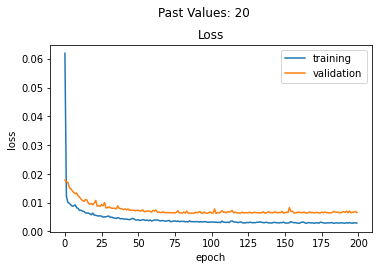

In [14]:
plot_results(
    title=f"Past Values: {PAST}",
    loss=history.history["loss"],
    val_loss=history.history["val_loss"],
)

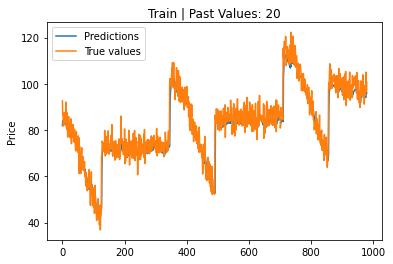

In [15]:
# Train predictions
plot_predictions(
    model,
    scaler,
    x_train,
    y_train,
    title=f"Train | Past Values: {PAST}"
)

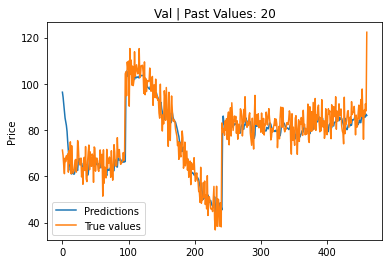

In [16]:
# Test predictions
plot_predictions(
    model,
    scaler,
    x_val,
    y_val,
    title=f"Val | Past Values: {PAST}"
)

## Future Prediction

In [17]:
n_val = val_data.shape[0]
test_data = np.concatenate((val_data[n_val-PAST:], np.zeros((FUTURE, 1))))

for i in range(PAST, FUTURE + PAST):
    batch = test_data[i-PAST:i].T
    batch = np.expand_dims(batch, axis=2)
    prediction = model.predict(batch)
    test_data[i] = np.squeeze(prediction)

test_data = scaler.inverse_transform(test_data)
past_values = test_data[:PAST]
future_values = test_data[PAST+1:]

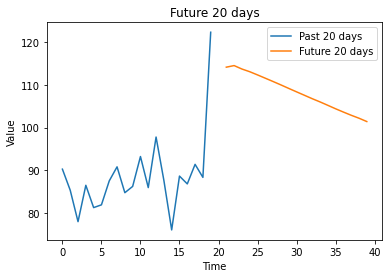

In [18]:
plt.plot(range(0, PAST), past_values)
plt.plot(range(PAST+1, PAST+FUTURE), future_values)
plt.title("Future 20 days")
plt.xlabel("Time")
plt.ylabel('Value')
plt.legend (["Past 20 days", "Future 20 days"])
plt.show()

# Simple RNN

## Model

In [21]:
def simple_model_factory(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.SimpleRNN(units=50, return_sequences=True)(inputs)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.SimpleRNN(units=50, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.SimpleRNN(units=50, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.SimpleRNN(units=50, return_sequences=False)(x)
    outputs = tf.keras.layers.Dense(units=1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
    )
    return model

In [22]:
model = simple_model_factory(input_shape)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 50)            2600      
                                                                 
 dropout_6 (Dropout)         (None, 20, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 50)            5050      
                                                                 
 dropout_7 (Dropout)         (None, 20, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20, 50)            5050      
                                                                 
 dropout_8 (Dropout)         (None, 20, 50)            0   

## Train

In [23]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/200
31/31 [==============================] - 4s 38ms/step - loss: 0.2121 - val_loss: 0.0136
Epoch 2/200
31/31 [==============================] - 1s 22ms/step - loss: 0.0513 - val_loss: 0.0108
Epoch 3/200
31/31 [==============================] - 1s 25ms/step - loss: 0.0238 - val_loss: 0.0102
Epoch 4/200
31/31 [==============================] - 1s 24ms/step - loss: 0.0208 - val_loss: 0.0115
Epoch 5/200
31/31 [==============================] - 1s 24ms/step - loss: 0.0154 - val_loss: 0.0104
Epoch 6/200
31/31 [==============================] - 1s 23ms/step - loss: 0.0127 - val_loss: 0.0110
Epoch 7/200
31/31 [==============================] - 1s 22ms/step - loss: 0.0124 - val_loss: 0.0111
Epoch 8/200
31/31 [==============================] - 1s 22ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 9/200
31/31 [==============================] - 1s 22ms/step - loss: 0.0109 - val_loss: 0.0097
Epoch 10/200
31/31 [==============================] - 1s 23ms/step - loss: 0.0098 - val_loss: 0.0098

## Results

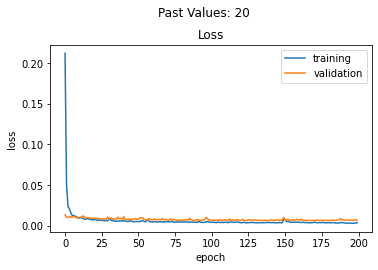

In [24]:
plot_results(
    title=f"Past Values: {PAST}",
    loss=history.history["loss"],
    val_loss=history.history["val_loss"],
)

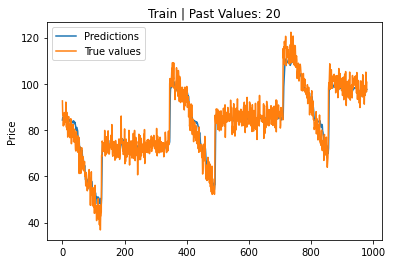

In [25]:
# Train predictions
plot_predictions(
    model,
    scaler,
    x_train,
    y_train,
    title=f"Train | Past Values: {PAST}"
)

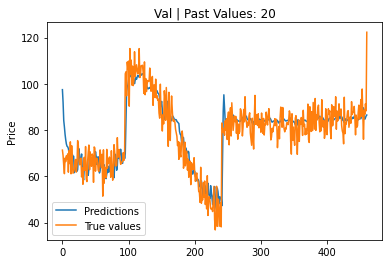

In [26]:
# Test predictions
plot_predictions(
    model,
    scaler,
    x_val,
    y_val,
    title=f"Val | Past Values: {PAST}"
)

## Future Predection

In [27]:
n_val = val_data.shape[0]
test_data = np.concatenate((val_data[n_val-PAST:], np.zeros((FUTURE, 1))))

for i in range(PAST, FUTURE + PAST):
    batch = test_data[i-PAST:i].T
    batch = np.expand_dims(batch, axis=2)
    prediction = model.predict(batch)
    test_data[i] = np.squeeze(prediction)

test_data = scaler.inverse_transform(test_data)
past_values = test_data[:PAST]
future_values = test_data[PAST+1:]

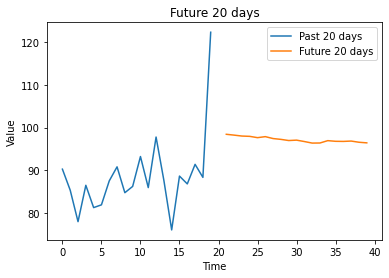

In [28]:
plt.plot(range(0, PAST), past_values)
plt.plot(range(PAST+1, PAST+FUTURE), future_values)
plt.title("Future 20 days")
plt.xlabel("Time")
plt.ylabel('Value')
plt.legend (["Past 20 days", "Future 20 days"])
plt.show()